#Uma implementação da Siamese Network para encontrar semelhanças de imagem

Nas Siamese Network existem dois conjuntos idênticos de camadas convolucionais que realmente compartilham filtros, ou seja eles têm duas entradas e têm apenas uma saída, então você tem duas imagens de entrada, por exemplo, e apenas uma pontuação de saída.

Nesse modelo pode receber duas entradas e dizer como elas são semelhantes, obviamente, as redes neurais convolucionais são realmente boas em identificar recursos, o que elas fazem primeiro é extrair os vetores de recursos de cada imagem e depois eles são recombinados em um único vetor, tomando a diferença absoluta entre os dois vetores de recursos, finalmente, o vetor de recursos único é colocado na função sigmoid que gera uma pontuação de semelhança e isso nos diz em alto nível o quão semelhantes essas duas entradas realmente são.
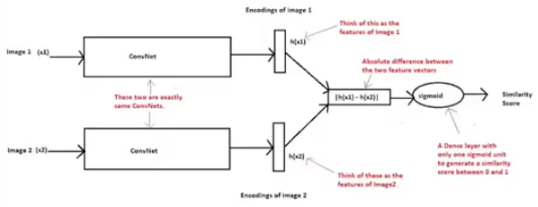

Exemplo para que possamos visualizar todo o seu conceito,

Digamos que queremos inserir duas faces em nosso modelo e ver como elas são semelhantes ou se pertencem à mesma pessoa nas duas imagens de entrada. Se forem semelhantes, elas teriam vetores de recursos semelhantes, isso significara uma diferença absoluta mais baixa e, portanto, uma pontuação de semelhança mais alta.

## Preparação de ambiente 

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers, utils, callbacks

## Leitura da base de dados

Nossos dados de entrada consistirão em pares de imagens e a saída será 1 ou 0 indicando se o par é semelhante ou não

In [7]:
def cria_pares(imagens, labels, seed=19):
    np.random.seed(seed)
    parimagens = []
    parLabels = []
    nClasses = len(np.unique(labels))
    idx = [np.where(labels == i)[0] for i in range(nClasses)]
    for idxA in range(len(imagens)):
        imagem_atual = imagens[idxA]
        label = labels[idxA]
        idxB = np.random.choice(idx[label])
        posImagem = imagens[idxB]
        parimagens.append([imagem_atual, posImagem])
        parLabels.append([1])
        negIdx = np.where(labels != label)[0]
        posImagem = imagens[np.random.choice(negIdx)]
        parimagens.append([imagem_atual, posImagem])
        parLabels.append([0])
    return (np.array(parimagens), np.array(parLabels))   


Train: (120000, 2, 28, 28, 1)
Test: (20000, 2, 28, 28, 1)


CPU times: user 19.6 s, sys: 1.4 s, total: 21 s
Wall time: 27.1 s


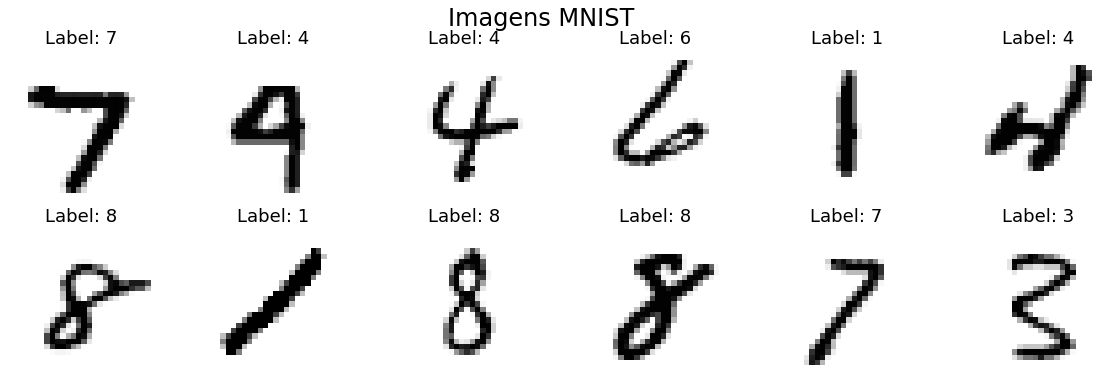

In [8]:
%%time
(trainX, trainY), (testX, testY) = mnist.load_data()
trainX = 1 - (trainX / 255.0)
testX  = 1 - (testX / 255.0)
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)

(parTrain, labelTrain) = cria_pares(trainX, trainY)
(parTest, labelTest) = cria_pares(testX, testY)

print(f'\nTrain: {parTrain.shape}')
print(f'Test: {parTest.shape}\n\n')


fig, ax = plt.subplots(2, 6, figsize=(20, 6))
random.seed(19)
idx = random.choices(range(len(trainX)), k=12)
for i in range(12):
    ax[i//6][i%6].imshow(np.squeeze(trainX[idx[i]]), cmap='gray')
    ax[i//6][i%6].set_title(f'Label: {trainY[idx[i]]}', fontsize=18)
    ax[i//6][i%6].set_axis_off()
fig.suptitle('Imagens MNIST', fontsize=24);

## Métricas
Com Siamese Network, as duas funções de perda mais usadas são:

contrastive loss
triplet loss



In [9]:
def loss(margin=1):
    def contrastive_loss(y_true, y_pred):
        y_true = tf.cast(y_true, y_pred.dtype)
        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss

## Modelo

### Configurações

In [10]:
class config():
    IMG_SHAPE = (28, 28, 1)
    EMBEDDING_DIM = 48
    TAMANHO = 64
    EPOCHS = 500

Função para calcular a distância euclidiana entre dois vetores. Isso será usado pelo nosso modelo para calcular a distância euclidiana entre os vetores dos pares de imagens (os vetores de imagem serão criados pelo extrator de recursos do nosso modelo)

In [11]:
def euclidean_distance(vectors):
    (featsA, featsB) = vectors
    sumSquared = K.sum(K.square(featsA - featsB), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sumSquared, K.epsilon()))

### Arquitetura de modelo

O modelo contém duas camadas de entrada
Um extrator de recursos através do qual ambas as imagens serão passadas para gerar vetores de recursos, o extrator de recursos normalmente consiste em camadas convolucionais e de agrupamento
Os vetores de recursos são passados por uma camada personalizada para obter a distância euclidiana entre os vetores
A camada final consiste em uma única unidade sigmóide

In [14]:
class SiameseNetwork(Model):
    def __init__(self, inputShape, embeddingDim):
        super(SiameseNetwork, self).__init__()        
        imgA = layers.Input(shape=inputShape)
        imgB = layers.Input(shape=inputShape)
        featureExtractor = self.build_feature_extractor(inputShape, embeddingDim)
        etapaA = featureExtractor(imgA)
        etapaB = featureExtractor(imgB)
        distancia = layers.Lambda(euclidean_distance, name='euclidean_distancia')([etapaA, etapaB])
        outputs = layers.Dense(1, activation="sigmoid")(distancia)
        self.model = Model(inputs=[imgA, imgB], outputs=outputs)        
        
    def build_feature_extractor(self, inputShape, embeddingDim=48):
        model = Sequential([
            layers.Input(inputShape),
            layers.Conv2D(64, (2, 2), padding="same", activation="relu"),
            layers.MaxPooling2D(pool_size=2),
            layers.Dropout(0.3),
            layers.Conv2D(64, (2, 2), padding="same", activation="relu"),
            layers.MaxPooling2D(pool_size=2),
            layers.Dropout(0.3),
            layers.Conv2D(128, (1, 1), padding="same", activation="relu"),
            layers.Flatten(),
            layers.Dense(embeddingDim, activation='tanh')
        ])

        return model  
        
    def call(self, x):
        return self.model(x)

In [15]:
model = SiameseNetwork(inputShape=config.IMG_SHAPE, embeddingDim=config.EMBEDDING_DIM)
model.compile(loss=loss(margin=1), optimizer="adam", metrics=["accuracy"])

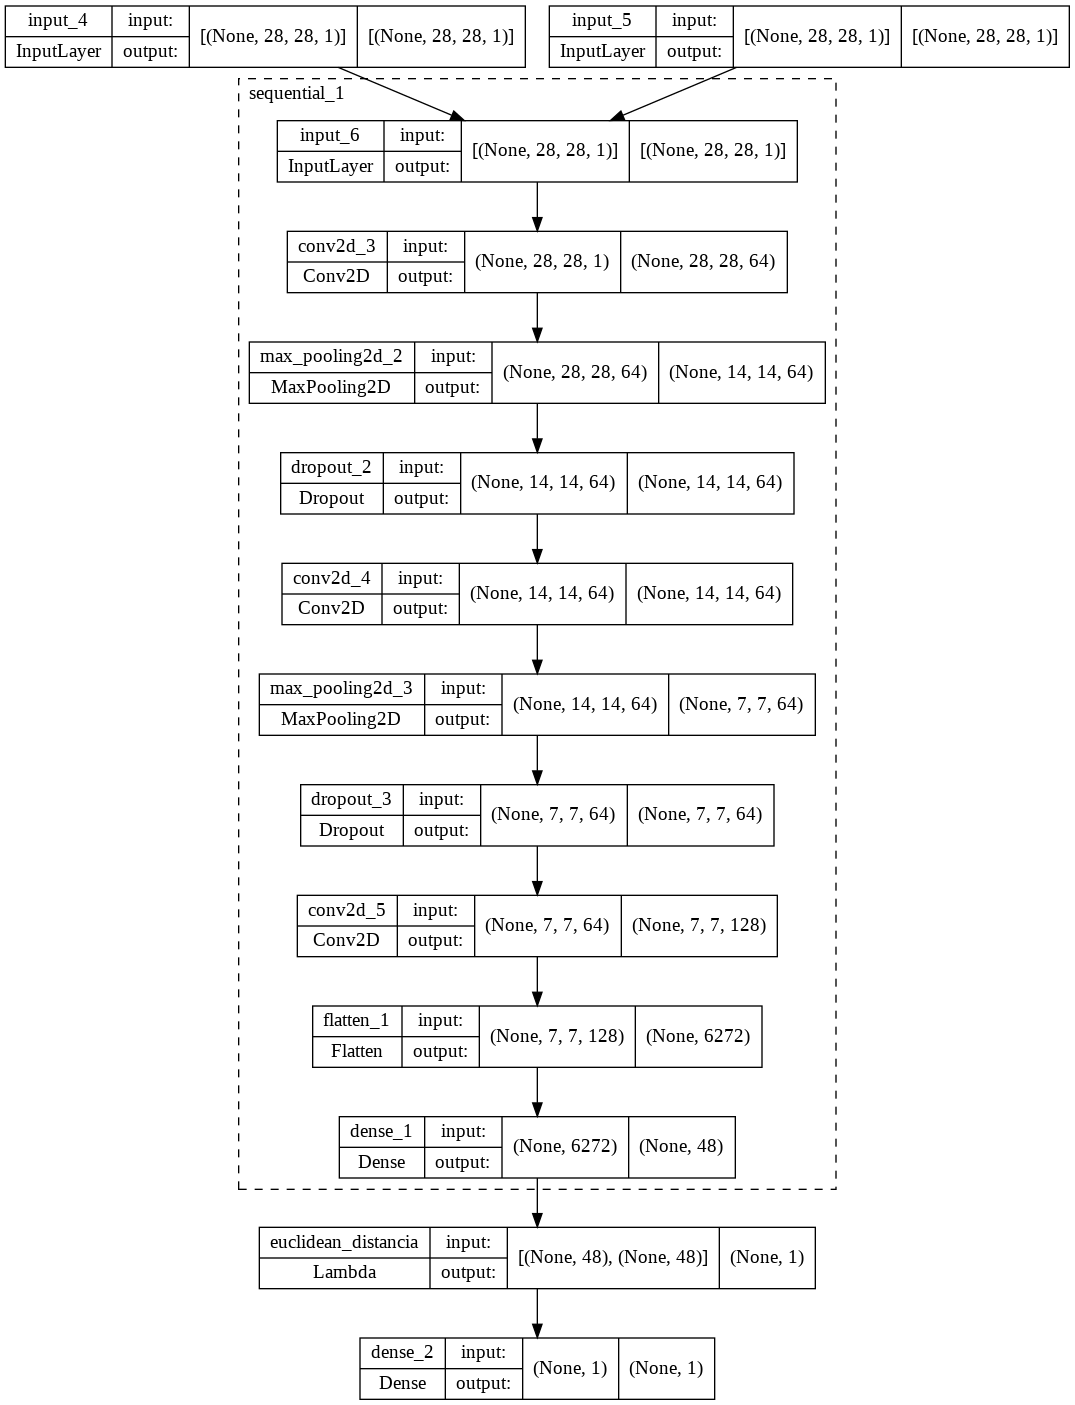

In [16]:
utils.plot_model(model.model, show_shapes=True, expand_nested=True)

## Execução

In [20]:
es = callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True, min_delta=1e-4)
rlp = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, mode='min', verbose=1)

history = model.fit(
    [parTrain[:, 0], parTrain[:, 1]], labelTrain[:],
    validation_data=([parTest[:, 0], parTest[:, 1]], labelTest[:]),
    batch_size=config.TAMANHO, 
    epochs=config.EPOCHS,
    callbacks=[es, rlp]
)

Epoch 1/500
1875/1875 [==============================] - 374s 199ms/step - loss: 0.2500 - accuracy: 0.5004 - val_loss: 0.2500 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/500
1875/1875 [==============================] - 322s 172ms/step - loss: 0.2500 - accuracy: 0.4981 - val_loss: 0.2500 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/500
1875/1875 [==============================] - 321s 171ms/step - loss: 0.2500 - accuracy: 0.4999 - val_loss: 0.2500 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/500
1875/1875 [==============================] - ETA: 0s - loss: 0.2500 - accuracy: 0.5017
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1875/1875 [==============================] - 320s 171ms/step - loss: 0.2500 - accuracy: 0.5017 - val_loss: 0.2500 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/500
1875/1875 [==============================] - 322s 172ms/step - loss: 0.2500 - accuracy: 0.4988 - val_loss: 0.2500 - val_accuracy: 0.5000 - lr: 5.0000e-04
Epoch 6/500
1875/1875 [

## Visualização dos resultados

amostra do nosso conjunto de dados

In [23]:
for i in range(0, 12, 2):
    ax[i//6][i%6].imshow(np.squeeze(parTest[idx[i//2]][0]), cmap='gray')
    ax[i//6][i%6+1].imshow(np.squeeze(parTest[idx[i//2]][1]), cmap='gray')
    ax[i//6][i%6].set_title(f'Label: {labelTest[idx[i//2]]}', fontsize=18)
    ax[i//6][i%6+1].set_title(f'Predicted: {np.round(preds[idx[i//2]], 2)}', fontsize=18)
    ax[i//6][i%6].set_axis_off()
    ax[i//6][i%6+1].set_axis_off()
fig.suptitle('Test Imagens', fontsize=24);

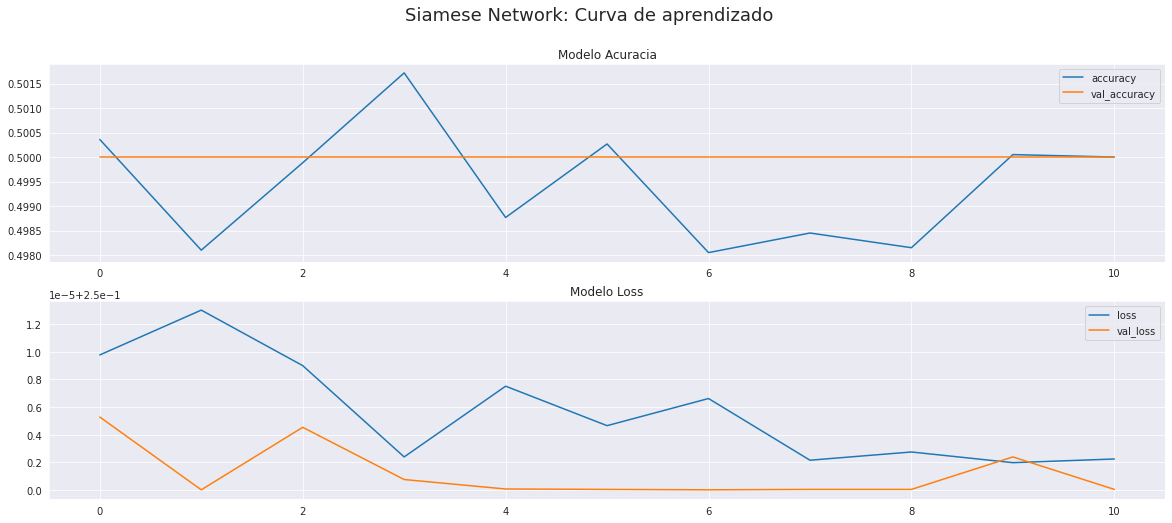

In [25]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(2, 1, figsize=(20, 8))
df = pd.DataFrame(history.history)
df[['accuracy', 'val_accuracy']].plot(ax=ax[0])
df[['loss', 'val_loss']].plot(ax=ax[1])
ax[0].set_title('Modelo Acuracia', fontsize=12)
ax[1].set_title('Modelo Loss', fontsize=12)
fig.suptitle('Siamese Network: Curva de aprendizado', fontsize=18);